# Convolutional Neural Network
We use a supervised convolutional neural network in this file to classify images into five categories.

## CNN (no_epochs = 10, batch_size = 32) on original datasets
### Import the necessary libraries

In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
import platform
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, LeakyReLU, BatchNorm2d, MaxPool2d, Dropout, Linear, ReLU, CrossEntropyLoss

### Use gpu on Mac
Computers with Intel chips can use `torch.cuda.is_availabe` to run on GPU. However, the newest Mac computers use Apple M1/M2 chips instead of Intel chips. Thus, we can use `torch.backends.mps.is_built()` to run on GPU.

In [2]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Windows-11-10.0.22631-SP0
MPS (Apple Metal) is NOT AVAILABLE
Target device is cpu


### Define the hyperparameters
In the following part, we define the following hyperparameters.
- `no_classes`: the number of classes
- `no_epoches`: the number of times the entire data set is passed forward and backward through the neural network
- `batch_size`: the number of samples used in one forward and backward pass through the network
- `learning_rate`: a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function
Initially, `no_classes` is 5, `no_epoches` is 10, `batch_size` is 32, and `learning_rate` is 0.001

In [3]:
no_classes = 5
no_epochs = 10
batch_size = 32
learning_rate = 0.001

### Other preparation

In [4]:
img_path = 'final_dataset'
label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

### ImageDataset class
This ImageDataset class is used with `DataLoader` to load images with proper labels. The ImageDataset class must have `__len__` and `__getitem__` methods to cooperate `DataLoader`. 

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, label_map, transform=None):
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        self.images = []
        self.labels = []
        
        for name, num in label_map.items():
            for img_name in os.listdir(os.path.join(img_dir, name)):
                img_path = os.path.join(img_dir, name, img_name)
                self.images.append(img_path)
                self.labels.append(num)
            print(f"finish to read all {name} images")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

### Load images and split into the training sets and testing sets

Test-size = 20% of available data
Train-size = 80% of remaining data.
Validation-size = 20% of remaining data.

In [6]:
dataset = ImageDataset(img_path, label_map, transform=transforms)
test_size = int(len(dataset) * 0.2)
rem_size = len(dataset) - test_size 
train_size = int(rem_size * 0.8)
val_size = rem_size - train_size 

test_dataset, rem_dataset = torch.utils.data.random_split(dataset, [test_size, rem_size])
train_dataset, val_dataset = torch.utils.data.random_split(rem_dataset, [train_size, val_size])
print(f"Length of Test Data : {len(test_dataset)}")
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images
Length of Test Data : 592
Length of Train Data : 1894
Length of Validation Data : 474


### CNNModel class
This class defines the neural network layers and fully connected layers. 
#### Neural network layers
`Conv2d` defines a convolutional neural network:
- `in_channels`: Initially, the input channel is 3 because of RGB images. Other input channels need to be matched with the previous output channel.
- `out_channels`: output channel
- `kernel_size`: we use 3*3 kernel to calculate matrix multiplication
- `stride`: we do not jump pixels when we move the kernel.
- `padding`: we add one pixel of padding around the input images

`BatchNorm2d`: batch normalization to normalize the input of each layer so that they have a mean of zero and a standard deviation of one

`LeakyReLU`: activation function

`MaxPool2d`: The max pooling layer picks the max value inside the windows 2*2.
#### Fully connected layers
- `Dropout`: there is a 10% chance that any given input unit will be set to zero during training.
- `Linear`: linear layers perform a linear transformation on the input data.
- `ReLU`: activation function
#### Size changes
Initial input: 3 * 64 * 64 (64*64 pixels, RGB images)
- After `Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)`: 32 * 64 * 64 (output channel is 32)
- After `MaxPool2d(stride=2, kernel_size=2)` of layer 1: 32 * 32 * 32 ((64 pixels/2 kernel_size) * (64 pixels/2 kernel_size))
- After `Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)`: 64 * 32 * 32 (output channel is 64)
- After `MaxPool2d(stride=2, kernel_size=2)` of layer 2: 64 * 16 * 16
- After `Linear(64*16*16, 1000)`: 1000
- After `Linear(1000, 512)`: 512
- After `Linear(512, no_classes)`: 5
#### Forward
Go through the neural network layers, flatten the images and go through the fully connected layers.

In [7]:
class CNNModel(Module):
    def __init__(self, no_classes):
        super(CNNModel, self).__init__()
        self.layer1 = Sequential(
            Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.layer2 = Sequential(
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.fc1 = Sequential(
            Dropout(p=0.1),
            Linear(64*16*16, 1000),
            ReLU(inplace=True),
            Linear(1000, 512),
            ReLU(inplace=True),
            Dropout(p=0.1),
            Linear(512, no_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

### Define the model, loss function and Optimizer

In [8]:
model = CNNModel(no_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train the model

Use the validation dataset to get accuracy and mean loss at the end of each epoch.

In [9]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def validation_step(model, batch):
    images, labels = batch 
    out = model(images)          
    loss = criterion(out, labels)
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(model, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model, outputs)

def epoch_end(model, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))


results = []
for epoch in range(no_epochs):
    model.train()
    train_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        train_losses.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print(f"Epoch: {epoch+1}/{no_epochs}, Step: {i+1}/{len(train_loader)}, Loss: {loss.item()}")
    
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    epoch_end(model, epoch, result)
    results.append(result)


Epoch: 1/10, Step: 20/60, Loss: 1.3157764673233032
Epoch: 1/10, Step: 40/60, Loss: 1.4101874828338623
Epoch: 1/10, Step: 60/60, Loss: 1.8961893320083618
Epoch [0], train_loss: 1.6353, val_loss: 1.1145, val_acc: 0.5069
Epoch: 2/10, Step: 20/60, Loss: 1.147082805633545
Epoch: 2/10, Step: 40/60, Loss: 0.8891021609306335
Epoch: 2/10, Step: 60/60, Loss: 0.9811201095581055
Epoch [1], train_loss: 1.0948, val_loss: 1.0966, val_acc: 0.5905
Epoch: 3/10, Step: 20/60, Loss: 1.021835207939148
Epoch: 3/10, Step: 40/60, Loss: 1.2797818183898926
Epoch: 3/10, Step: 60/60, Loss: 2.41078519821167
Epoch [2], train_loss: 1.0060, val_loss: 0.9539, val_acc: 0.5995
Epoch: 4/10, Step: 20/60, Loss: 0.8508176207542419
Epoch: 4/10, Step: 40/60, Loss: 0.8931490182876587
Epoch: 4/10, Step: 60/60, Loss: 1.067539095878601
Epoch [3], train_loss: 0.8934, val_loss: 0.9185, val_acc: 0.6197
Epoch: 5/10, Step: 20/60, Loss: 1.0977367162704468
Epoch: 5/10, Step: 40/60, Loss: 0.5693123936653137
Epoch: 5/10, Step: 60/60, Loss:

Plotting Loss vs Number of Epochs:

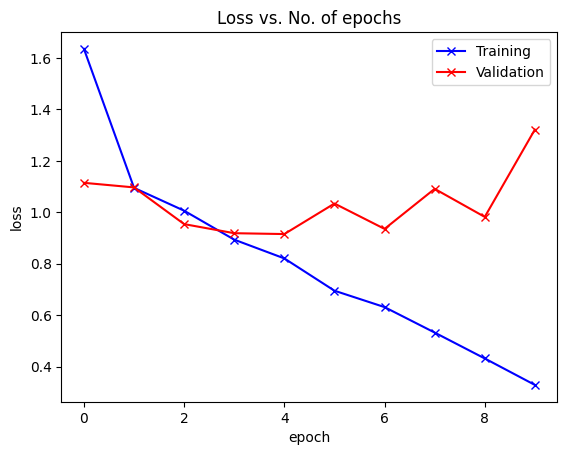

In [10]:
import matplotlib.pyplot as plt

def plot_losses(results):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in results]
    val_losses = [x['val_loss'] for x in results]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(results)

In [11]:
Plotting Accuracy vs Number of Epochs:

SyntaxError: invalid syntax (2711011008.py, line 1)

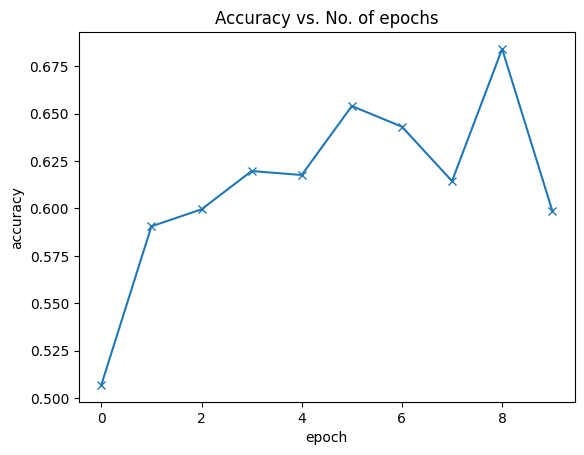

In [12]:
def plot_accuracies(results):
    """ Plot the results of accuracies"""
    accuracies = [x['val_acc'] for x in results]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(results)

### Evaluation

Overall Accuracy: 0.6030; Precision: 0.6585; Recall: 0.6097; F1: 0.5977
Class bar - Accuracy: 0.7228; Precision: 0.3527; Recall: 0.7228; F1-score: 0.4740
Class beach - Accuracy: 0.9618; Precision: 0.9692; Recall: 0.9618; F1-score: 0.9655
Class bookstore - Accuracy: 0.3333; Precision: 0.8525; Recall: 0.3333; F1-score: 0.4793
Class restaurant - Accuracy: 0.4082; Precision: 0.3846; Recall: 0.4082; F1-score: 0.3960
Class subway - Accuracy: 0.6226; Precision: 0.7333; Recall: 0.6226; F1-score: 0.6735


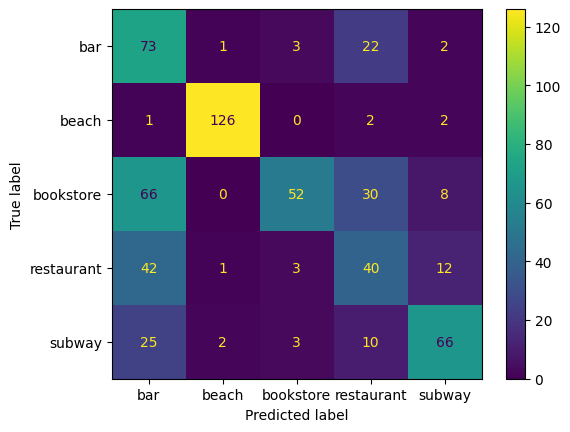

In [13]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    class_correct = [0] * len(label_map)
    class_total = [0] * len(label_map)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Overall Accuracy: {accuracy:.4f}; Precision: {precision:.4f}; Recall: {recall:.4f}; F1: {f1:.4f}")

    for i in range(len(label_map)):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        class_prec = precision_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_rec = recall_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_f1 = f1_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        print(f"Class {list(label_map.keys())[i]} - Accuracy: {class_acc:.4f}; Precision: {class_prec:.4f}; Recall: {class_rec:.4f}; F1-score: {class_f1:.4f}")

    conf_matrix = confusion_matrix(true_labels, predicted_labels)    
    confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
    confusion_matrix_display.plot()
    plt.show()

In [14]:
#save the model
torch.save(model.state_dict(), 'Epoch10OriginalDataModel.pth')

## CNN (no_epochs = 20, batch_size = 128) on original datasets

Python Platform: Windows-11-10.0.22631-SP0
MPS (Apple Metal) is NOT AVAILABLE
Target device is cpu
finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images
Length of Test Data : 592
Length of Train Data : 1894
Length of Validation Data : 474
Epoch [0], train_loss: 2.8050, val_loss: 1.1960, val_acc: 0.4927
Epoch [1], train_loss: 1.1574, val_loss: 1.1557, val_acc: 0.5214
Epoch [2], train_loss: 1.0207, val_loss: 1.0199, val_acc: 0.5789
Epoch [3], train_loss: 0.9709, val_loss: 0.9952, val_acc: 0.5992
Epoch [4], train_loss: 0.9230, val_loss: 0.9766, val_acc: 0.6115
Epoch [5], train_loss: 0.8230, val_loss: 0.9305, val_acc: 0.6413
Epoch [6], train_loss: 0.7855, val_loss: 0.9486, val_acc: 0.6232
Epoch [7], train_loss: 0.7213, val_loss: 0.9323, val_acc: 0.5936
Epoch [8], train_loss: 0.6701, val_loss: 0.9697, val_acc: 0.6359
Epoch [9], train_loss: 0.6415, val_loss: 1.0355, val_acc: 0.61

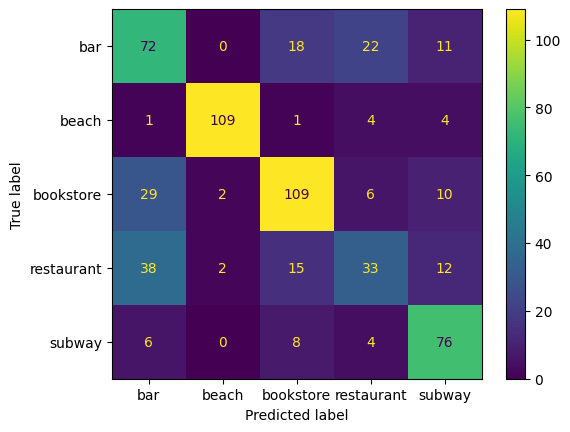

In [15]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
import platform
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, LeakyReLU, BatchNorm2d, MaxPool2d, Dropout, Linear, ReLU, CrossEntropyLoss

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

no_classes = 5
no_epochs = 20
batch_size = 128
learning_rate = 0.001
img_path = 'final_dataset'
label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

class ImageDataset(Dataset):
    def __init__(self, img_dir, label_map, transform=None):
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        self.images = []
        self.labels = []
        
        for name, num in label_map.items():
            for img_name in os.listdir(os.path.join(img_dir, name)):
                img_path = os.path.join(img_dir, name, img_name)
                self.images.append(img_path)
                self.labels.append(num)
            print(f"finish to read all {name} images")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

dataset = ImageDataset(img_path, label_map, transform=transforms)
test_size = int(len(dataset) * 0.2)
rem_size = len(dataset) - test_size 
train_size = int(rem_size * 0.8)
val_size = rem_size - train_size 

test_dataset, rem_dataset = torch.utils.data.random_split(dataset, [test_size, rem_size])
train_dataset, val_dataset = torch.utils.data.random_split(rem_dataset, [train_size, val_size])
print(f"Length of Test Data : {len(test_dataset)}")
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


class CNNModel(Module):
    def __init__(self, no_classes):
        super(CNNModel, self).__init__()
        self.layer1 = Sequential(
            Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.layer2 = Sequential(
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.fc1 = Sequential(
            Dropout(p=0.1),
            Linear(64*16*16, 1000),
            ReLU(inplace=True),
            Linear(1000, 512),
            ReLU(inplace=True),
            Dropout(p=0.1),
            Linear(512, no_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = CNNModel(no_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def validation_step(model, batch):
    images, labels = batch 
    out = model(images)          
    loss = criterion(out, labels)
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(model, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model, outputs)

def epoch_end(model, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))


results = []
for epoch in range(no_epochs):
    model.train()
    train_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        train_losses.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print(f"Epoch: {epoch+1}/{no_epochs}, Step: {i+1}/{len(train_loader)}, Loss: {loss.item()}")
    
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    epoch_end(model, epoch, result)
    results.append(result)
        
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    class_correct = [0] * len(label_map)
    class_total = [0] * len(label_map)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Overall Accuracy: {accuracy:.4f}; Precision: {precision:.4f}; Recall: {recall:.4f}; F1: {f1:.4f}")

    for i in range(len(label_map)):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        class_prec = precision_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_rec = recall_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_f1 = f1_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        print(f"Class {list(label_map.keys())[i]} - Accuracy: {class_acc:.4f}; Precision: {class_prec:.4f}; Recall: {class_rec:.4f}; F1-score: {class_f1:.4f}")

    conf_matrix = confusion_matrix(true_labels, predicted_labels)    
    confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
    confusion_matrix_display.plot()
    plt.show()
    
#save the model
#torch.save(model.state_dict(), 'Epoch20Batch128OriginalDataModel.pth')


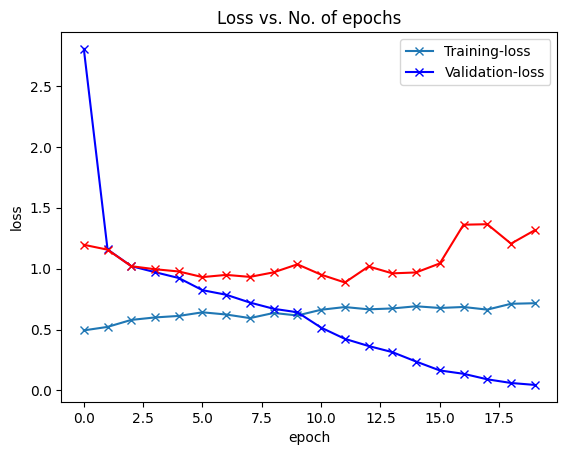

In [16]:
import matplotlib.pyplot as plt

def plot_accuracies(results):
    """ Plot the results of accuracies"""
    accuracies = [x['val_acc'] for x in results]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Accuracy'])
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(results)

def plot_losses(results):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in results]
    val_losses = [x['val_loss'] for x in results]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training-loss', 'Validation-loss'])
    plt.title('Loss vs. No. of epochs');

plot_losses(results)

## CNN (no_epochs = 20, batch_size = 128) on augmented datasets
`img_path = 'final_dataset_augmentated'`

Python Platform: Windows-11-10.0.22631-SP0
MPS (Apple Metal) is NOT AVAILABLE
Target device is cpu
finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images
Length of Test Data : 630
Length of Train Data : 2016
Length of Validation Data : 505
Epoch [0], train_loss: 2.5926, val_loss: 1.3937, val_acc: 0.4413
Epoch [1], train_loss: 1.1752, val_loss: 0.9742, val_acc: 0.5860
Epoch [2], train_loss: 0.9230, val_loss: 0.7922, val_acc: 0.6575
Epoch [3], train_loss: 0.7301, val_loss: 0.7395, val_acc: 0.6948
Epoch [4], train_loss: 0.6213, val_loss: 0.6797, val_acc: 0.7186
Epoch [5], train_loss: 0.5201, val_loss: 0.6601, val_acc: 0.7110
Epoch [6], train_loss: 0.4765, val_loss: 0.6096, val_acc: 0.7502
Epoch [7], train_loss: 0.4042, val_loss: 0.5378, val_acc: 0.7823
Epoch [8], train_loss: 0.3919, val_loss: 0.6768, val_acc: 0.7349
Epoch [9], train_loss: 0.3075, val_loss: 0.5136, val_acc: 0.80

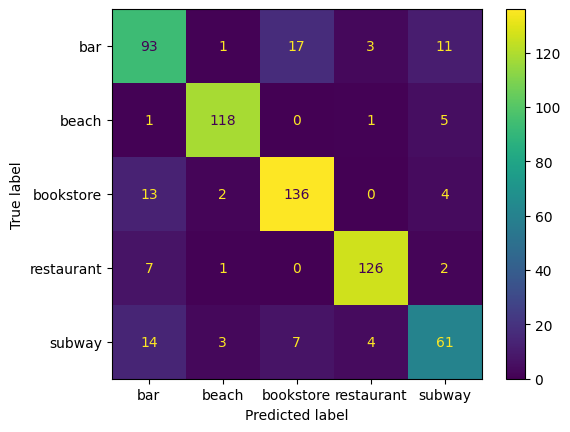

In [17]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
import platform
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, LeakyReLU, BatchNorm2d, MaxPool2d, Dropout, Linear, ReLU, CrossEntropyLoss

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

no_classes = 5
no_epochs = 20
batch_size = 128
learning_rate = 0.001
img_path = 'final_dataset_augmentated'
label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

class ImageDataset(Dataset):
    def __init__(self, img_dir, label_map, transform=None):
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        self.images = []
        self.labels = []
        
        for name, num in label_map.items():
            for img_name in os.listdir(os.path.join(img_dir, name)):
                img_path = os.path.join(img_dir, name, img_name)
                self.images.append(img_path)
                self.labels.append(num)
            print(f"finish to read all {name} images")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

dataset = ImageDataset(img_path, label_map, transform=transforms)
test_size = int(len(dataset) * 0.2)
rem_size = len(dataset) - test_size 
train_size = int(rem_size * 0.8)
val_size = rem_size - train_size 

test_dataset, rem_dataset = torch.utils.data.random_split(dataset, [test_size, rem_size])
train_dataset, val_dataset = torch.utils.data.random_split(rem_dataset, [train_size, val_size])
print(f"Length of Test Data : {len(test_dataset)}")
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


class CNNModel(Module):
    def __init__(self, no_classes):
        super(CNNModel, self).__init__()
        self.layer1 = Sequential(
            Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.layer2 = Sequential(
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.fc1 = Sequential(
            Dropout(p=0.1),
            Linear(64*16*16, 1000),
            ReLU(inplace=True),
            Linear(1000, 512),
            ReLU(inplace=True),
            Dropout(p=0.1),
            Linear(512, no_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = CNNModel(no_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def validation_step(model, batch):
    images, labels = batch 
    out = model(images)          
    loss = criterion(out, labels)
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(model, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model, outputs)

def epoch_end(model, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))


results = []
for epoch in range(no_epochs):
    model.train()
    train_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        train_losses.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print(f"Epoch: {epoch+1}/{no_epochs}, Step: {i+1}/{len(train_loader)}, Loss: {loss.item()}")
    
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    epoch_end(model, epoch, result)
    results.append(result)
        
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    class_correct = [0] * len(label_map)
    class_total = [0] * len(label_map)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Overall Accuracy: {accuracy:.4f}; Precision: {precision:.4f}; Recall: {recall:.4f}; F1: {f1:.4f}")

    for i in range(len(label_map)):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        class_prec = precision_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_rec = recall_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_f1 = f1_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        print(f"Class {list(label_map.keys())[i]} - Accuracy: {class_acc:.4f}; Precision: {class_prec:.4f}; Recall: {class_rec:.4f}; F1-score: {class_f1:.4f}")

    conf_matrix = confusion_matrix(true_labels, predicted_labels)    
    confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
    confusion_matrix_display.plot()
    plt.show()
    
#save the model
#torch.save(model.state_dict(), 'Epoch20Batch128OAugmentedDataModel.pth')


In [ ]:
import matplotlib.pyplot as plt

def plot_accuracies(results):
    """ Plot the results of accuracies"""
    accuracies = [x['val_acc'] for x in results]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Accuracy'])
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(results)

def plot_losses(results):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in results]
    val_losses = [x['val_loss'] for x in results]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training-loss', 'Validation-loss'])
    plt.title('Loss vs. No. of epochs');

plot_losses(results)